# Data Challenge 1:
## Framing the problem
### A company sells software for \\$39 and recently experimented with presenting users a higher price point of \\$59. The VP of product wants to know:
1. Should the company sell its software for \\$39 or \\$59
1. Are there actionable insights available from the available data. 
1. Could these results have been knowable more quickly? Did we run it too long?

### Translated into tasks these might be rewritten as:
1. Did we convert more people with \\$39 compared to \\$59? Did we make more money with \\$39 or \\$59?
    1. Success here could be statistical significance (more money or not). Could also be practical significance (e.g., user feedback to company with increased price) - we don't have those data. 
1. Can we predict conversion (binary classification) as a function of the available features? Model could be used to individualize price point presented. 
    1. Success here measured by predictive ability of model and relative feature importance. 
1. Simple power analysis: How many observations needed to be collected to answer each question above?
    1. Success here measured by identifying the number of observations needed to detect a statistically significant difference.  

## Quick Answers:
1. More people in the \\$39 group converted than in the \\$59 group. However, the company earned more money per person in the \\$59 group than in the \\$39 group. ANSWER: The company should price their software at \\$59. 
1. ANSWER: Yes! Optimized for recall because we don't want to lose a sale we thought we had. When this is done we find that IndividualId and geographical location were highest ranked features. This suggests individually targeted ads specific to region might improve sales. 
1. ANSWER: Yes, the test was run too long. From a statistically significant perspective, only ~ 1500 observations were needed. However, when starting this process I would have obtained more information on a specific effect size that would be meaningful to the company. That might change the estimate as I assumed a small effect size. 

# Exploring, cleaning, and preprocessing data

In [1]:
# Packages we'll be using. 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Test Results Table

In [2]:
# Get a quick sense of what we're working with
data_test = pd.read_csv('test_results.csv')
test_results = data_test.copy()
test_results = test_results.drop('Unnamed: 0', axis=1)
tr_cols = list(test_results)
print(test_results.dtypes)

user_id               int64
timestamp            object
source               object
device               object
operative_system     object
test                  int64
price               float64
converted             int64
dtype: object


In [3]:
# Check out what kinds of data exist for each variable in the 'test_results' table. 
for i in tr_cols:
    print("Missing:", test_results[i].isna().sum(), "\n", test_results[i].value_counts(), "\n")

Missing: 0 
 2047      1
338394    1
465846    1
407572    1
753429    1
         ..
291876    1
293925    1
857669    1
814119    1
2049      1
Name: user_id, Length: 316800, dtype: int64 

Missing: 334 
 2015-04-12 11:51:16    12
2015-05-25 07:27:08    11
2015-04-10 08:29:07    11
2015-04-04 17:38:26    11
2015-05-21 22:12:24    10
                       ..
2015-04-25 09:34:54     1
2015-04-24 09:58:58     1
2015-05-19 07:39:39     1
2015-05-01 20:33:22     1
2015-03-21 17:33:57     1
Name: timestamp, Length: 141147, dtype: int64 

Missing: 312 
 direct_traffic     60307
ads-google         59319
ads_facebook       53337
ads_other          29849
seo-google         23160
ads-bing           22851
seo_facebook       21185
friend_referral    20672
seo-other           9250
ads-yahoo           7573
seo-yahoo           6836
seo-bing            2149
Name: source, dtype: int64 

Missing: 0 
 mobile    186471
web       130329
Name: device, dtype: int64 

Missing: 20339 
 windows    100878
iOS  

### Takeaways : solutions from the test_results table
- "converted" imbalanced: use random over-sampling to increase the signal in the noise
- "operative_system" has ~20,000 missing vals: recode as an 'unknown' category
- 'iOS' & 'windows' coded two different ways: fix spelling errors
- "price" has outliers: remove from analysis
- "timestamp" has ~300 missing vals: drop from the analysis
- 'source' has ~ 300 missing vals: drop form the analysis

### Implement the solutions to above takeaways

In [4]:
# Recode 'operative _system' issues noted above
test_results['operative_system'] = test_results['operative_system'].fillna('unknown') # chose to recode b/c of large n and possible other users will be unknown
test_results['operative_system'] = test_results['operative_system'].replace('wnddows', 'windows')
test_results['operative_system'] = test_results['operative_system'].replace('i0S', 'iOS')
test_results['operative_system'] = test_results['operative_system'].replace('anroid', 'android')
test_results['operative_system'] = test_results['operative_system'].replace('apple', 'unknown')
test_results['operative_system'].value_counts()

windows    100976
iOS         95465
android     74935
mac         25056
unknown     20368
Name: operative_system, dtype: int64

In [5]:
# Remove outliers based on 'price' column
test_results = test_results[test_results['price'] < 60]
test_results['price'].value_counts()

39.0    200747
59.0    112979
Name: price, dtype: int64

In [6]:
# Remove rows with missing vals from timestamp and source
test_results = test_results.dropna()
cols = ['timestamp', 'source']
for i in cols:
    print("Missing:", test_results[i].isna().sum(), "\n", test_results[i].value_counts(), "\n")

Missing: 0 
 2015-04-12 11:51:16    12
2015-04-10 08:29:07    11
2015-05-25 07:27:08    11
2015-04-04 17:38:26    11
2015-03-26 11:59:06    10
                       ..
2015-04-11 17:27:25     1
2015-03-22 07:03:38     1
2015-04-17 04:32:08     1
2015-03-07 18:41:29     1
2015-03-27 13:04:40     1
Name: timestamp, Length: 140634, dtype: int64 

Missing: 0 
 direct_traffic     59666
ads-google         58686
ads_facebook       52738
ads_other          29533
seo-google         22911
ads-bing           22592
seo_facebook       20953
friend_referral    20458
seo-other           9142
ads-yahoo           7499
seo-yahoo           6781
seo-bing            2128
Name: source, dtype: int64 



In [7]:
# Test the veracity of experimental control
# Should see only '0' and '59' if the test group data is appropriately labeled
test_results['mult'] = test_results['test'] * test_results['price']
print("Unique:", test_results['mult'].unique(), '\n\nCounts:', test_results['mult'].value_counts())

Unique: [ 0. 59. 39.] 

Counts: 0.0     200409
59.0    112525
39.0       153
Name: mult, dtype: int64


In [8]:
# Output suggests 153 people were labeled as'test' group but saw $39 price. 
# Recode these to accurate test labels
test_results['mult'] = test_results['mult'].replace(39, 0) # Recode error $39 to match control group 0
test_results['mult'] = test_results['mult'].replace(59, 1) # Recode 59 to 1
# Now the mult column contains the accurate test labels
print("Unique:", test_results['mult'].unique(), '\n\nCounts:', test_results['mult'].value_counts())

Unique: [0. 1.] 

Counts: 0.0    200562
1.0    112525
Name: mult, dtype: int64


In [9]:
# Drop mislabeled 'test' col and change 'mult' col label to 'test'
test_results = test_results.drop(['test'], axis=1)
test_results = test_results.rename(columns={'mult':'test'})

## User Table Data: EDA & Cleaning

In [10]:
# Get a quick sense of what we're working with
data_user = pd.read_csv('user_table.csv')
user_table = data_user.copy()
usr_cols = list(user_table)
print(user_table.dtypes)

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object


In [11]:
for i in usr_cols:
    print("Missing:", user_table[i].isna().sum(), "\n", user_table[i].value_counts(), "\n")

Missing: 0 
 2047      1
658708    1
783659    1
779561    1
257320    1
         ..
639403    1
609923    1
83586     1
87680     1
2049      1
Name: user_id, Length: 275616, dtype: int64 

Missing: 0 
 New York       25748
Chicago         7153
Houston         6706
San Antonio     4633
Los Angeles     4141
               ...  
Cerritos           1
Costa Mesa         1
Ocala              1
New Milford        1
East Lake          1
Name: city, Length: 923, dtype: int64 

Missing: 0 
 USA    275616
Name: country, dtype: int64 

Missing: 0 
 40.67    25901
41.84     7478
29.77     6706
29.46     4633
34.11     4475
         ...  
36.53        3
39.30        3
35.12        3
26.45        3
27.98        1
Name: lat, Length: 713, dtype: int64 

Missing: 0 
 -73.94     25748
-87.68      7153
-95.39      6706
-98.51      4633
-118.41     4141
           ...  
-82.38         1
-73.41         1
-118.07        1
-73.51         1
-82.13         1
Name: long, Length: 830, dtype: int64 



(array([  892.,     0., 26450., 50549., 40770., 62020., 94598.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,   337.]),
 array([-157.8       , -145.25933333, -132.71866667, -120.178     ,
        -107.63733333,  -95.09666667,  -82.556     ,  -70.01533333,
         -57.47466667,  -44.934     ,  -32.39333333,  -19.85266667,
          -7.312     ,    5.22866667,   17.76933333,   30.31      ]),
 <a list of 15 Patch objects>)

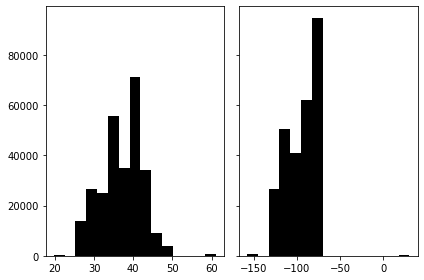

In [12]:
# Histogram of latitude and longitude
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(user_table['lat'], bins=15, color='black')
axs[1].hist(user_table['long'], bins=15, color='black')

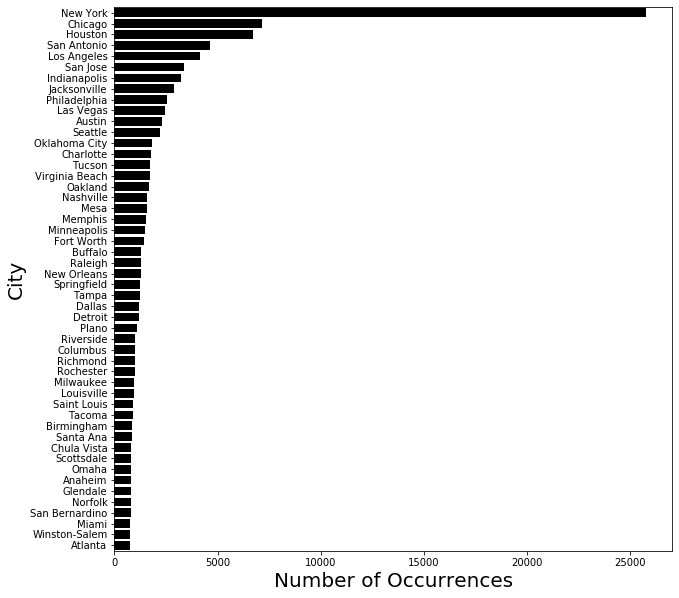

In [13]:
# Bar plot of counts per city. 
city_count = user_table['city'].value_counts()
city_count = city_count[:50,]
plt.figure(figsize=(10,10))
sns.barplot(city_count.values, city_count.index, color='black')
plt.ylabel('City', fontsize=20)
plt.xlabel('Number of Occurrences', fontsize=20)
plt.show()

In [14]:
cols = list(user_table)
for i in user_table:
    print("Num Unique", i, ":", len((user_table[i].unique())), "\n\n")

Num Unique user_id : 275616 


Num Unique city : 923 


Num Unique country : 1 


Num Unique lat : 713 


Num Unique long : 830 




### Takeaways from the user_table:
- Imbalanced classes for city - recode into regions of country?
- Only one country - drop

In [15]:
# Drop country form user_table
user_table = user_table.drop(['country'], axis=1)
print(list(user_table))

['user_id', 'city', 'lat', 'long']


## Merge the two tables into one

In [16]:
merged_data = pd.merge(test_results, user_table, on="user_id", how='inner') # chose to keep only vals common to both
merged_data.to_csv('merged_data.csv') # Save work thus far

In [17]:
# Price and test cols are now redundant. Drop test so we an play with revenue estimates from pricing later.
# Still in the merged_data.csv so we can bring back later if needed. 
# Drop timestamp data for now
merged_data = merged_data.drop(['test'], axis=1)
merged_data = merged_data.drop('user_id', axis=1)

## Recode strings as numbers for ML algorithms

In [18]:
merged_data.dtypes

timestamp            object
source               object
device               object
operative_system     object
price               float64
converted             int64
city                 object
lat                 float64
long                float64
dtype: object

In [19]:
cats_recode = merged_data.copy()

# Recode timestamp via label encoding
cats_recode = merged_data.copy()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cats_recode['timestamp'] = cats_recode['timestamp'].astype('category')
cats_recode['timestamp'] = cats_recode['timestamp'].cat.codes

# Recode other cols via one-hot encoding
cols_recode = ['source', 'device', 'operative_system', 'city']
cats_recode = pd.get_dummies(cats_recode, columns = cols_recode)
cats_recode.shape # Check out the new shape

(272382, 947)

In [20]:
# Save this point in the pipeline
cats_recode.to_csv('cats_recode.csv')

## Question 1: Did we convert more people using \\$59? Did we make more money using \\$39?

In [21]:
# Calculate proportions of people who were in each condition and converted. 
prop_39_data = cats_recode.loc[cats_recode['price']==39] # Create df for $39 group
prop_59_data = cats_recode.loc[cats_recode['price']==59] # Create df for #59 group
num_39_convert = prop_39_data['converted'].value_counts() # Get nums for contingency table
num_59_convert = prop_59_data['converted'].value_counts() # Get nums for contingency table
prop_39_convert = (prop_39_data['converted'].sum()) / (len(prop_39_data)) # Get proportion of conversions
prop_59_convert = (prop_59_data['converted'].sum()) / (len(prop_59_data)) # Get proportion of conversions
print("$39 Nums:", num_39_convert, "\n$59 Nums:", num_59_convert, \
      "\n$39 Convert Prop:", round(prop_39_convert, 4), "\n$59 Convert Prop:", round(prop_59_convert, 4))

$39 Nums: 0    170903
1      3445
Name: converted, dtype: int64 
$59 Nums: 0    96514
1     1520
Name: converted, dtype: int64 
$39 Convert Prop: 0.0198 
$59 Convert Prop: 0.0155


In [22]:
# McNemar test because conversions are proportions and come from a binomial distribution
from statsmodels.stats.contingency_tables import mcnemar
table = [[170903, 3445], 
         [96514, 1520]]
result = mcnemar(table, exact=True) # exact set to true so we're using the binomial distribution, not chi-squared distribution
print('statistic = %.3f; \np-value = %.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
	print('\nSame proportions of conversion. The test is unlikely to have influenced conversion.')
else:
	print('\nDifferent proportions of conversions. It\'s unlikely we would have observed these data if the pricing difference did not influence conversions.')

statistic = 3445.000; 
p-value = 0.000

Different proportions of conversions. It's unlikely we would have observed these data if the pricing difference did not influence conversions.


In [23]:
# Calculate total money earned per person in each condition. 
money_earned_39 = (3445*39) / (len(prop_39_data)) # Money earned per person exposed
money_earned_59 = (1520*59) / (len(prop_59_data)) # Money earned per person exposed
print("$39 Earned per person:", round(money_earned_39, 4), "\n$59 Earned per person:", round(money_earned_59, 4))

$39 Earned per person: 0.7706 
$59 Earned per person: 0.9148


In [24]:
# Mann-Whitney test because groups are unmatched and money per person comes from a non-Gaussian distribution
from scipy.stats import mannwhitneyu
money_39 = prop_39_data.loc[:, ['price', 'converted']]
money_59 = prop_59_data.loc[:, ['price', 'converted']]
money_39['mon_earned'] = money_39['price']*money_39['converted']
money_59['mon_earned'] = money_59['price']*money_59['converted']
# compare samples
stat, p = mannwhitneyu(money_39['mon_earned'], money_59['mon_earned'])
print('Statistic=%.3f; \np=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('\nSame distribution. The test us unlikely to have influenced overall money earned.')
else:
	print('\nDifferent distribution. It\'s unlikely we would have observed these data if the pricing differences did not influence the overal amount of money earned.')

Statistic=8512275031.000; 
p=0.000

Different distribution. It's unlikely we would have observed these data if the pricing differences did not influence the overal amount of money earned.


# Question 2: Are there actionable insights from the data?

### Start with seeing how well we can predict conversion. All three business questions seem to focus on conversion (i.e., binary classification). 
### Because feature importance matters, algorithms without that info are not helpful (e.g., kNN). 
### Algorithms to test:
1. Logistic classifier
1. Support vector machine
1. Random Forest

In [25]:
# Stuff we'll need throughout
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
features = cats_recode.drop(['converted'], axis=1)
outcome = cats_recode['converted']

In [26]:
# Resampling the minority class of conversion (i.e., first run through led to difficulties with convergence and funky outputs). 
from imblearn.over_sampling import RandomOverSampler # Using naive random sampler as it seemed the simplest and I was most comfortable with the process
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(features, outcome)

In [27]:
# Some functions we'll use. 
def bin_metrics(x, y):
    '''Prints four common metrics for evaluating classification predictions.'''
    print('Accuracy:', round(metrics.accuracy_score(x, y), 4))
    print('Precision:', round(metrics.precision_score(x, y), 4))
    print('Recall:', round(metrics.recall_score(x, y), 4))
    print('ROC_AUC:,', round(metrics.roc_auc_score(x, y), 4))
    print('F1:', round(metrics.f1_score(x, y), 4))

def plot_cm(x, y):
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20}, fmt='g')# font size
    plt.ylim([0, 2])

## Logistic Classifier:
- Advantages: less prone to over-fitting (except with high-dimensional data); gives size and direction of predictors; easy to implement, interpret, and train. 
- Disadvantages: assumption of linearity between variables

Accuracy: 0.5704
Precision: 0.5738
Recall: 0.5605
ROC_AUC:, 0.5704
F1: 0.5671


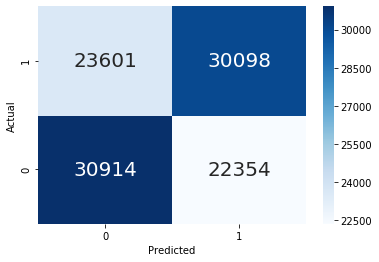

In [28]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X_resampled,  y_resampled, test_size=0.20, random_state=333)
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
bin_metrics(y_test, y_pred)
plot_cm(y_test, y_pred)

## Support Vector Machine:
- Advantages: Effective in high dimensional spaces (this project) and uses a subset of training points in the decision function so it is memory efficient.
- Disadvantages: Does not directly provide probability estimates but are calculated using expensive five-fold cross-validation.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Max Accuracy: 0.5263
Max F1: 0.6259


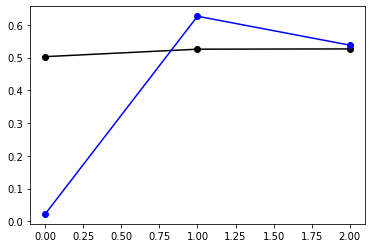

In [29]:
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(X_resampled,  y_resampled, test_size=0.20, random_state = 333)
acc_scores = []
f1_scores = []
C_range = [0.01, 1, 100]
for i in C_range:
    classifier = svm.LinearSVC(C=i, max_iter=10000)
    classifier.fit(X_train, y_train)
    pred_train= classifier.predict(X_train)
    pred_test= classifier.predict(X_test)
    acc_val = metrics.accuracy_score(y_test, pred_test)
    acc_scores.append(acc_val)
    f1_val = f1_score(y_test, pred_test)
    f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 4))
print('Max F1:', round(max(f1_scores), 4))

## Random Forest:
- Advantages: Less-probability of over-fitting and random forest more accurate than decision trees in most cases.
- Disadvantages: Slow real time prediction (not an issue?), difficult to implement, and complex algorithm.

Max Accuracy: 0.9935
Max F1: 0.9936


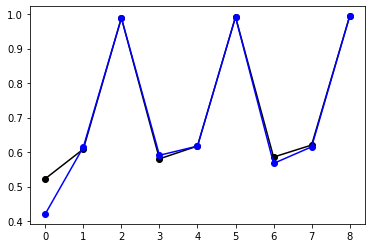

In [30]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_resampled,  y_resampled, test_size=0.20, random_state = 333)
acc_scores = []
f1_scores = []
nEst_range = [10, 50, 500]
depth_range = [2, 10, 100]
for i in nEst_range:
    for k in depth_range:
        classifier = RandomForestClassifier(n_estimators=i, max_depth=k)
        classifier.fit(X_train, y_train)
        pred_train= classifier.predict(X_train)
        pred_test= classifier.predict(X_test)
        acc_val = metrics.accuracy_score(y_test, pred_test)
        acc_scores.append(acc_val)
        f1_val = f1_score(y_test, pred_test)
        f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 4))
print('Max F1:', round(max(f1_scores), 4))

### The RF model seemed to do best. We'll use RF with the optimal hyperparams from above as the final model. This can give us an idea of feature importance for actionable insights. 

Accuracy: 0.9889
Precision: 0.9817
Recall: 0.9965
ROC_AUC:, 0.9889
F1: 0.989


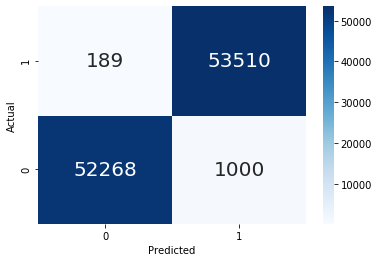

In [31]:
# Create final model to get feature importance
X_train, X_test, y_train, y_test = train_test_split(X_resampled,  y_resampled, test_size=0.20, random_state = 333)
classifier = RandomForestClassifier(n_estimators=10, max_depth=100)
classifier.fit(X_train, y_train)
pred_train= classifier.predict(X_train)
pred_test= classifier.predict(X_test)
acc_val = metrics.accuracy_score(y_test, pred_test)
f1_val = f1_score(y_test, pred_test)
bin_metrics(y_test, pred_test)
plot_cm(y_test, pred_test)

In [32]:
feature_importances = pd.DataFrame(classifier.feature_importances_, index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(10))

                          importance
timestamp                   0.307259
lat                         0.069498
long                        0.068317
price                       0.024565
source_friend_referral      0.018726
source_direct_traffic       0.011154
source_ads_facebook         0.007800
source_seo-google           0.007436
operative_system_android    0.007416
source_ads-google           0.007366


### Actionable insights: The most important features seem to be (1) time and individual, &  (2) geographical location . These can be used to:
- Increase/add data collection on individual user information. Might allow for more individualized and targeted ads in the future. 
- These data suggest more rigorous analysis of geographical location might improve individualized, targeted adds. This might involve a next A/B test of geographical boundaries. 
- Where users are coming from and the operating system they're using doesn't seem to matter - i.e., no worries about individualizing adds or website experiences based on these variables. 

# Question #3: Was the test run for to long? Assuming statistical difference is the deciding factor, then a power analysis would give us that answer. 

In [33]:
import statsmodels.stats.power as power
chipower = power.GofChisquarePower()
eff_01 = chipower.solve_power(effect_size=0.1, nobs=None, alpha=0.05, power=0.9, n_bins=4)
eff_05 = chipower.solve_power(effect_size=0.5, nobs=None, alpha=0.05, power=0.9, n_bins=4)
eff_09 = chipower.solve_power(effect_size=0.9, nobs=None, alpha=0.05, power=0.9, n_bins=4)
print("Number of Observations Needed to Detect Effect Size of:\n", "0.01:", round(eff_01, 0), "\n0.05:", \
      round(eff_05, 0), "\n0.09:", round(eff_09, 0))

Number of Observations Needed to Detect Effect Size of:
 0.01: 1417.0 
0.05: 57.0 
0.09: 17.0


### It looks like a small effect of pricing on conversion should be detectable with ~ 1500 observations. This is much smaller than the total number of observations used in the test (n=275,000). 

Max Accuracy: 0.99
Max F1: 0.99


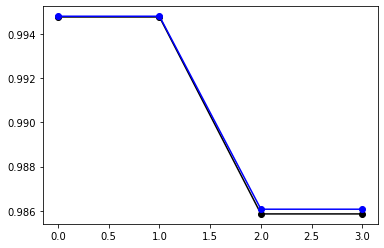

In [34]:
#k-NN:
# Advantages: This algorithm is simple to implement, robust to noisy training data, and effective if training data is large.
# Disadvantages: Need to determine the value of K and the computation cost is high as it needs to computer the distance of each instance to all the training samples.
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X_resampled,  y_resampled, test_size=0.20, random_state = 0)
acc_scores = []
f1_scores = []
neigh_range = list(range(1, 5))
for i in neigh_range:
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train, y_train)
    pred_train= classifier.predict(X_train)
    pred_test= classifier.predict(X_test)
    acc_val = metrics.accuracy_score(y_test, pred_test)
    acc_scores.append(acc_val)
    f1_val = f1_score(y_test, pred_test)
    f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 2))
print('Max F1:', round(max(f1_scores), 2))

Accuracy: 0.5704
Precision: 0.5738
Recall: 0.5605
ROC_AUC:, 0.5704
F1: 0.5671


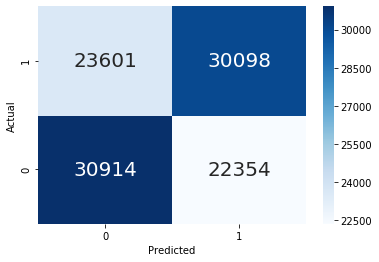

In [35]:
# Naive Bayes Classifier
# Benefits: simple, runs in linear time making it easy to scale. 
# Drawbacks: Zero probability problem; known to be a bad estimator
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state = 333)
classifier = GaussianNB()
classifier.fit(X_train, y_train)
pred_train= classifier.predict(X_train)
pred_test= classifier.predict(X_test)
bin_metrics(y_test, y_pred)
plot_cm(y_test, y_pred)